# Datos

**Maestría de Ciencias de Datos e Información**

**Integrantes:**

    Karen Itzel Velasco Chincoya,
    Martha Karina Terán Botello,
    Yuridiana de Jesús Reyes Delgado,

**Modelos Avanzados en Ciencia de Datos**

**Unidad 1 Actividad Exploración de datos**

Octubre 10, 2022

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition, impute
from sklearn.experimental import enable_iterative_imputer


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Información 

En este trabajo se uso una muestra de 10,000 registros para los siguientes algoritmos, ya que el volumen de datos dificulta su procesamiento. 

**Columnas:** Se eliminaron las columnas que no tuvieran un 75% de valores, eliminando 23 Columnas.

**PCA:** Para trabajar con el número de columnas del dataset, se aplica Principal Componen Analysis para realizar una reducción.



In [ ]:
train_df_sample = pd.read_csv('/content/train_df_sample.csv')
train_label_df = pd.read_csv('/content/train_label_df.csv')
train_df = pd.merge(train_df_sample, train_label_df, how="inner", on=["customer_ID"])
test_df = pd.read_csv('/content/test_df.csv')
sample_submission_df = pd.read_csv('/content/sample_submission_df.csv')

# Explora los datos del problema


In [ ]:
print("-------- Archivo de Entrenamiento ----------")
print("Filas:",train_df.shape[0]," Columnas:",train_df.shape[1])
train_df.info()
display(train_df.head())
print("\n")
print("-------- Archivo de Pruebas ----------")
print("Filas:",test_df.shape[0]," Columnas:",test_df.shape[1])
test_df.info()
display(test_df.head())

-------- Archivo de Entrenamiento ----------
Filas: 10000  Columnas: 193
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 193 entries, Unnamed: 0_x to target
dtypes: float64(185), int64(4), object(4)
memory usage: 14.8+ MB


,Unnamed: 0_x,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,Unnamed: 0_y,target
0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,...,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0,0
1,1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,...,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0,0
2,2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,...,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0,0
3,3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,...,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0,0
4,4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,...,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0,0




-------- Archivo de Pruebas ----------
Filas: 10000  Columnas: 191
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 191 entries, Unnamed: 0 to D_145
dtypes: float64(185), int64(2), object(4)
memory usage: 14.6+ MB


,Unnamed: 0,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0.001912,0.010728,0.814497,0.007547,0.168651,0.009971,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008281,NaN
1,1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0.005275,0.011026,0.810848,0.001817,0.241389,0.000166,...,NaN,NaN,NaN,0.000142,0.004940,0.009021,NaN,0.003695,0.003753,0.001460
2,2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0.003326,0.016390,1.004620,0.000114,0.266976,0.004196,...,NaN,NaN,NaN,0.000074,0.002114,0.004656,NaN,0.003155,0.002156,0.006482
3,3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614911,0.009065,0.021672,0.816549,0.009722,0.188947,0.004123,...,NaN,NaN,NaN,0.004743,0.006392,0.002890,NaN,0.006044,0.005206,0.007855
4,4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591673,0.238794,0.015923,0.810456,0.002026,0.180035,0.000731,...,NaN,NaN,NaN,0.008133,0.004329,0.008384,NaN,0.001008,0.007421,0.009471


In [ ]:
clientes = train_df.groupby('target').count().reset_index()
clientes['Conteo'] = clientes['customer_ID']
clientes = clientes.filter(['target','Conteo'])
clientes

,target,Conteo
0,0,7447
1,1,2553


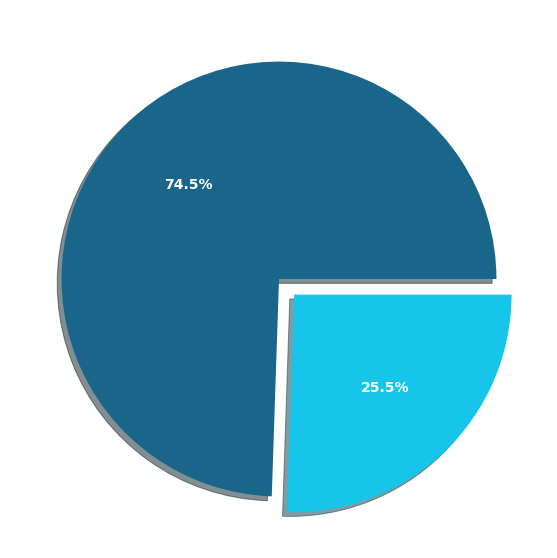

In [ ]:
plt.figure(figsize=(20,10))
plt.pie(clientes['Conteo'],
        labels=clientes['target'],
        colors=['#19668A','#17C4EA'],
        shadow=True,
        explode=[0, 0.1],
        autopct='%1.1f%%',
        textprops=dict(color="w", weight="bold", size=14)
       )
plt.show()


In [ ]:
anios = pd.to_datetime(test_df['S_2']).dt.year
anios

0       2019
1       2019
2       2019
3       2019
4       2019
        ... 
9995    2018
9996    2018
9997    2018
9998    2019
9999    2019
Name: S_2, Length: 10000, dtype: int64

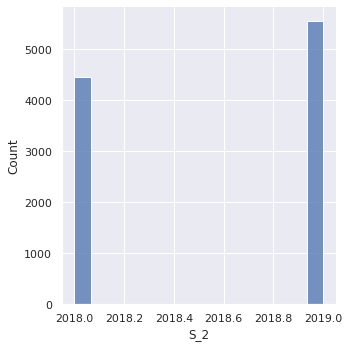

In [ ]:
grafica_barras = sns.displot(anios)

## Describe cual es la relación de tu variable objetivo con las demás variables presentes. 

La relación es que las diferentes variables indicadas de los rubros de **Delincuencia (D), Gasto (S), Pago (P), Saldo (B) y Riesgo (R)** nos permiten calificar la capacidad de pago de un cliente o no.

Las registros que tienen un target=1(Pago) representa el 25.4% mientras que los que tienen un target=0(No pago) son el 74.6% 

## Determina cuales son las variables que tienen mayor correlación con tu objetivo. 
 

In [ ]:
columnas_categoricas = train_df[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64','D_68']]
columnas_categoricas

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,3.0,0.0,0.0,-1.0,0.0,1.0,CR,O,6.0
9996,0.0,3.0,0.0,0.0,-1.0,0.0,1.0,CR,O,6.0
9997,0.0,2.0,1.0,0.0,-1.0,0.0,1.0,CO,O,6.0
9998,0.0,3.0,1.0,0.0,-1.0,0.0,1.0,CO,O,6.0


In [ ]:
columnas_categoricas.isnull().sum()
columnas_categoricas

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,3.0,0.0,0.0,-1.0,0.0,1.0,CR,O,6.0
9996,0.0,3.0,0.0,0.0,-1.0,0.0,1.0,CR,O,6.0
9997,0.0,2.0,1.0,0.0,-1.0,0.0,1.0,CO,O,6.0
9998,0.0,3.0,1.0,0.0,-1.0,0.0,1.0,CO,O,6.0


In [ ]:
LabelEncoder = preprocessing.LabelEncoder()
columnas_categoricas = columnas_categoricas.apply(LabelEncoder.fit_transform)
columnas_categoricas

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
0,0,1,1,0,4,0,2,2,1,6
1,0,1,1,0,4,0,2,2,1,6
2,0,1,1,0,4,0,2,2,1,6
3,0,1,1,0,4,0,2,2,1,6
4,0,1,1,0,4,0,2,2,1,6
...,...,...,...,...,...,...,...,...,...,...
9995,0,2,0,0,0,0,2,2,1,6
9996,0,2,0,0,0,0,2,2,1,6
9997,0,1,1,0,0,0,2,1,1,6
9998,0,2,1,0,0,0,2,1,1,6


In [ ]:
Encoder = preprocessing.OneHotEncoder()
Encoder.fit(columnas_categoricas)
ohl = Encoder.transform(columnas_categoricas).toarray()
ohl

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [ ]:
nombres_columnas_categoricas = Encoder.get_feature_names_out(list(columnas_categoricas.columns))
nombres_columnas_categoricas

array(['B_30_0', 'B_30_1', 'B_30_2', 'B_38_0', 'B_38_1', 'B_38_2',
       'B_38_3', 'B_38_4', 'B_38_5', 'B_38_6', 'D_114_0', 'D_114_1',
       'D_114_2', 'D_116_0', 'D_116_1', 'D_116_2', 'D_117_0', 'D_117_1',
       'D_117_2', 'D_117_3', 'D_117_4', 'D_117_5', 'D_117_6', 'D_117_7',
       'D_120_0', 'D_120_1', 'D_120_2', 'D_126_0', 'D_126_1', 'D_126_2',
       'D_126_3', 'D_63_0', 'D_63_1', 'D_63_2', 'D_63_3', 'D_63_4',
       'D_63_5', 'D_64_0', 'D_64_1', 'D_64_2', 'D_64_3', 'D_64_4',
       'D_68_0', 'D_68_1', 'D_68_2', 'D_68_3', 'D_68_4', 'D_68_5',
       'D_68_6', 'D_68_7'], dtype=object)

In [ ]:
df_cc = pd.DataFrame(ohl,columns=nombres_columnas_categoricas)
df_cc

,B_30_0,B_30_1,B_30_2,B_38_0,B_38_1,B_38_2,B_38_3,B_38_4,B_38_5,B_38_6,...,D_64_3,D_64_4,D_68_0,D_68_1,D_68_2,D_68_3,D_68_4,D_68_5,D_68_6,D_68_7
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9996,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9997,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9998,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_df = train_df.drop(columns = columnas_categoricas.columns)
train_df = train_df.join(df_cc)
train_df

,Unnamed: 0_x,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_64_3,D_64_4,D_68_0,D_68_1,D_68_2,D_68_3,D_68_4,D_68_5,D_68_6,D_68_7
0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,007793144e0eeef1e29a7aa93244815328beb0d46ccbe3...,2018-02-26,0.331150,1.472028,0.049780,0.187973,0.000417,0.143625,0.955153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9996,9996,007793144e0eeef1e29a7aa93244815328beb0d46ccbe3...,2018-03-19,0.361060,2.065567,0.048313,0.194930,0.006775,0.144908,1.252287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9997,9997,0077b7efafef4cfa81e42538b87e39799e9928e47c6826...,2017-03-28,0.708199,0.357349,0.013953,1.002573,0.003448,0.110258,0.170252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9998,9998,0077b7efafef4cfa81e42538b87e39799e9928e47c6826...,2017-04-15,0.692401,0.009380,0.018337,0.588057,0.001596,0.108820,0.177197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_df_x = train_df.drop(columns=['target'])
train_df_y = train_df[['target']]

In [ ]:
train_df_PCA = train_df_x.drop(columns=['customer_ID','S_2'])

In [ ]:
mv = impute.IterativeImputer()

In [ ]:
train_df_x_impute = mv.fit_transform(train_df_PCA)
train_df_x_impute

array([[0.00000000e+00, 9.38468719e-01, 1.73333900e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.36664605e-01, 5.77544307e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 9.54180277e-01, 9.15053968e-02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [9.99700000e+03, 7.08198594e-01, 3.57349217e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [9.99800000e+03, 6.92401424e-01, 9.38038431e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [9.99900000e+03, 7.79089561e-01, 4.45051691e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [ ]:
train_df_x_impute_df = pd.DataFrame(train_df_x_impute,columns=list(train_df_PCA.columns))

In [ ]:
correlation = columnas_categoricas.corr()
correlation

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
B_30,1.000000,0.552650,-0.107343,-0.039710,-0.101645,0.036912,-0.048972,-0.087249,0.089850,-0.098154
B_38,0.552650,1.000000,-0.165780,-0.127780,-0.168237,-0.015177,-0.074441,-0.096441,0.062872,-0.140624
D_114,-0.107343,-0.165780,1.000000,0.433167,0.199741,0.244399,0.221030,0.023940,-0.177099,0.316220
D_116,-0.039710,-0.127780,0.433167,1.000000,0.363936,0.697978,0.181348,0.004882,0.386644,0.235788
D_117,-0.101645,-0.168237,0.199741,0.363936,1.000000,0.207880,0.118046,0.003531,-0.080536,0.158986
D_120,0.036912,-0.015177,0.244399,0.697978,0.207880,1.000000,0.089669,-0.022383,0.334884,0.068663
D_126,-0.048972,-0.074441,0.221030,0.181348,0.118046,0.089669,1.000000,0.044564,-0.029564,0.216136
D_63,-0.087249,-0.096441,0.023940,0.004882,0.003531,-0.022383,0.044564,1.000000,0.013637,0.019347
D_64,0.089850,0.062872,-0.177099,0.386644,-0.080536,0.334884,-0.029564,0.013637,1.000000,-0.130481
D_68,-0.098154,-0.140624,0.316220,0.235788,0.158986,0.068663,0.216136,0.019347,-0.130481,1.000000


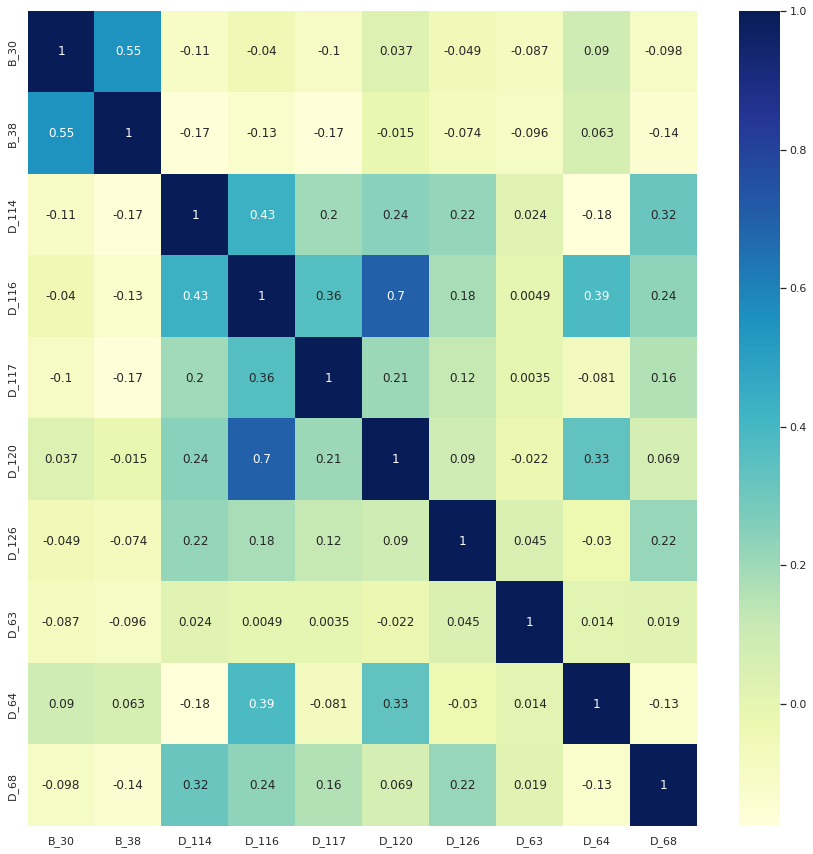

In [ ]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(correlation, cmap="YlGnBu", annot=True)
plt.show()

# Aplica ingeniería de características para diseñar nuevas características en tu conjunto de datos. 

## Principal Components Analysis

In [ ]:
pca = decomposition.PCA(n_components=20)
train_df_x_impute_pca = pca.fit_transform(train_df_x_impute_df)

In [ ]:
train_df_x_impute_pca = pd.DataFrame(train_df_x_impute_pca,columns=[f'col_{n}' for n in range(train_df_x_impute_pca.shape[1])])
train_df_x_impute_pca

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,-5016.429389,5.029292,-0.566677,-1.759820,-0.169626,0.064818,0.727785,-1.752733,0.402074,-0.068215,0.533210,1.033004,0.774144,0.393362,-0.405088,0.066108,0.236160,-0.638573,0.183339,0.557685
1,-5015.432777,5.042491,-0.564935,-1.770772,-0.171864,0.061448,0.722580,-1.755270,0.314375,-0.076976,0.530819,1.031638,0.766911,0.391826,-0.402450,0.060826,0.248761,-0.635160,0.190279,0.548049
2,-5014.436167,5.065249,-0.565415,-1.789778,-0.166171,0.065665,0.679107,-1.828626,0.231191,-0.064794,0.508150,1.022192,0.880116,0.342105,-0.385787,0.042180,0.282084,-0.672050,0.212418,0.508574
3,-5013.439551,5.071427,-0.563937,-1.761056,-0.171627,0.072088,0.751753,-1.797691,0.155535,-0.050741,0.484575,0.979193,0.780397,0.363720,-0.350476,0.033448,0.248970,-0.632360,0.205938,0.536527
4,-5012.442939,5.088301,-0.569223,-1.804571,-0.176053,0.060845,0.733471,-1.796760,0.070326,-0.053917,0.482665,0.994215,0.795227,0.366119,-0.365430,0.007594,0.261766,-0.640134,0.227234,0.529759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5012.479367,5.673910,-0.593856,-1.220979,6.725233,0.195253,-0.316751,-0.265343,0.558732,0.684234,-0.618105,0.523560,0.594868,1.206913,-0.580411,0.445623,-0.042515,0.091118,-1.026502,0.062051
9996,5013.475869,5.586827,-0.565340,-1.201882,1.565568,0.071781,-0.541174,-0.032835,0.513702,0.881794,-0.675891,0.770423,0.671060,1.414094,-0.670074,0.686940,-0.121440,0.167865,-1.186011,0.037967
9997,5014.555429,-4.035357,0.057812,-0.807885,-0.157565,0.174518,0.471454,-1.552087,0.524054,-0.075201,0.642295,0.835846,0.508874,-0.414478,-0.051408,0.002345,0.035674,0.042637,0.636258,0.320345
9998,5015.552075,-3.949422,0.072385,-0.645221,-0.108787,0.097300,0.076061,-1.126439,0.681329,0.224743,0.184424,1.138149,0.394930,-0.579473,-0.188751,-0.182034,-0.034444,0.438386,0.144826,-0.525184


In [ ]:
train_df_pca = train_df_y.join(train_df_x[['customer_ID', 'S_2']]).join(train_df_x_impute_pca)
train_df_pca

,target,customer_ID,S_2,col_0,col_1,col_2,col_3,col_4,col_5,col_6,...,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,-5016.429389,5.029292,-0.566677,-1.759820,-0.169626,0.064818,0.727785,...,0.533210,1.033004,0.774144,0.393362,-0.405088,0.066108,0.236160,-0.638573,0.183339,0.557685
1,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,-5015.432777,5.042491,-0.564935,-1.770772,-0.171864,0.061448,0.722580,...,0.530819,1.031638,0.766911,0.391826,-0.402450,0.060826,0.248761,-0.635160,0.190279,0.548049
2,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,-5014.436167,5.065249,-0.565415,-1.789778,-0.166171,0.065665,0.679107,...,0.508150,1.022192,0.880116,0.342105,-0.385787,0.042180,0.282084,-0.672050,0.212418,0.508574
3,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,-5013.439551,5.071427,-0.563937,-1.761056,-0.171627,0.072088,0.751753,...,0.484575,0.979193,0.780397,0.363720,-0.350476,0.033448,0.248970,-0.632360,0.205938,0.536527
4,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,-5012.442939,5.088301,-0.569223,-1.804571,-0.176053,0.060845,0.733471,...,0.482665,0.994215,0.795227,0.366119,-0.365430,0.007594,0.261766,-0.640134,0.227234,0.529759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,007793144e0eeef1e29a7aa93244815328beb0d46ccbe3...,2018-02-26,5012.479367,5.673910,-0.593856,-1.220979,6.725233,0.195253,-0.316751,...,-0.618105,0.523560,0.594868,1.206913,-0.580411,0.445623,-0.042515,0.091118,-1.026502,0.062051
9996,1,007793144e0eeef1e29a7aa93244815328beb0d46ccbe3...,2018-03-19,5013.475869,5.586827,-0.565340,-1.201882,1.565568,0.071781,-0.541174,...,-0.675891,0.770423,0.671060,1.414094,-0.670074,0.686940,-0.121440,0.167865,-1.186011,0.037967
9997,0,0077b7efafef4cfa81e42538b87e39799e9928e47c6826...,2017-03-28,5014.555429,-4.035357,0.057812,-0.807885,-0.157565,0.174518,0.471454,...,0.642295,0.835846,0.508874,-0.414478,-0.051408,0.002345,0.035674,0.042637,0.636258,0.320345
9998,0,0077b7efafef4cfa81e42538b87e39799e9928e47c6826...,2017-04-15,5015.552075,-3.949422,0.072385,-0.645221,-0.108787,0.097300,0.076061,...,0.184424,1.138149,0.394930,-0.579473,-0.188751,-0.182034,-0.034444,0.438386,0.144826,-0.525184


# Modela tus datos de dos o más formas diferentes para comparar los resultados. 



In [ ]:
x = train_df_pca.drop(columns=['target','customer_ID','S_2'])
y = train_df_pca['target']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

In [ ]:
print("X_train  Filas:",X_train.shape[0]," Columnas:",X_train.shape[1])
print("X_test Filas:",X_test.shape[0]," Columnas:",X_test.shape[1])
print("y_train Filas:",y_train.shape)
print("y_test Filas:",y_test.shape)

X_train  Filas: 7500  Columnas: 20
X_test Filas: 2500  Columnas: 20
y_train Filas: (7500,)
y_test Filas: (2500,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("Accuracy del modelo: ", metrics.accuracy_score(y_test, y_pred))


Accuracy del modelo:  0.9668


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("Accuracy del modelo: ", metrics.accuracy_score(y_test, y_pred))

Accuracy del modelo:  0.8552


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Conclusiones

Este trabajo permitió poner en práctica lo revisado en los cursos de la plataforma Kaggle: exploración de datos, ingeniería de características y Modelos de ML principalmente, así como la visualización de los datos.

Escogimos un tema donde el conjunto de datos era de un tamaño muy grande que resultaba complejo de manejar al ejecutar este notebook, por lo que se hizo un subconjunto para efectos de la codificación.



# Referencias

*   https://www.kaggle.com/code/girishkumarsahu/american-express-default-prediction-eda/notebook
*   https://www.kaggle.com/code/girishkumarsahu/american-express-default-prediction-ml-model
*   Jamieson Bolder, David. **Credit-Risk Modelling: Theoretical Foundations, Diagnostic Tools, Practical Examples, and Numerical Recipes in Python**. Springer 2018. 